<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Cambria";'>
Notebook Imports

In [3]:
!pip install optuna #for google collab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 16.1 MB/s 
     |████████████████████████████████| 209 kB 48.9 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 78 kB 3.8 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 112 kB 51.9 MB/s 
     |████████████████████████████████| 147 kB 51.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=55cc12487d5e8b6723936eed8b7501df52c6da018b0dcfecf1c1ee4d8ed5956c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import optuna

import tensorflow as tf

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Cambria";'>
Importing data

In [5]:
data = pd.read_csv('StudentsPerformance.csv')
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [6]:
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

- There are no missing values in this dataset

In [7]:
data.duplicated().sum()

0

In [8]:
data.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


- Mean maths score is lowest among the different type of scores.
- Half of the students have marks greater than or equal to 70 in reading exam

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Cambria";'>
Feature Engineering

- We can derive the following 2 features in this dataset using the different types of scores.
   - **Percentage**
   - **Grade**

In [10]:
data['Percentage'] = round((data['reading score'] + data['writing score'] + data['math score']) / 3, 2)

In [11]:
def Grade(percentage):
    if percentage >= 95: return "O"
    if percentage > 81 : return "A"
    if percentage > 71 : return "B"
    if percentage > 61 : return "C"
    if percentage > 51 : return "D"
    if percentage > 41 : return "E"
    else: return "F"

data["Grade"] = data['Percentage'].apply(lambda x: Grade(x))

In [12]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Percentage,Grade
0,female,group B,bachelor's degree,standard,none,72,72,74,72.67,B
1,female,group C,some college,standard,completed,69,90,88,82.33,A
2,female,group B,master's degree,standard,none,90,95,93,92.67,A
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.33,E
4,male,group C,some college,standard,none,76,78,75,76.33,B


<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Cambria";'>
Exploratory Data Analysis 

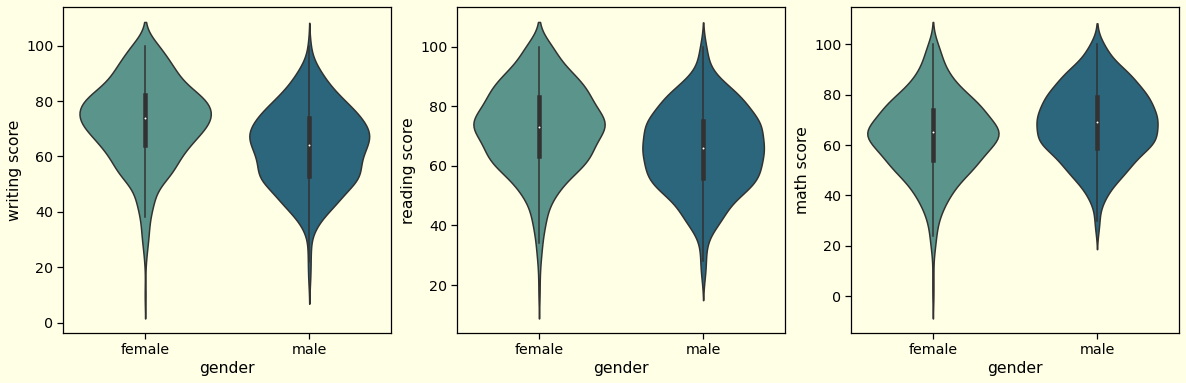

In [13]:
sns.set_context('notebook', font_scale= 1.3)
plt.rcParams['figure.facecolor'] = "#ffffe6"
plt.rcParams['axes.facecolor'] = "#ffffe6"
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
ax1 = sns.violinplot(x = data['gender'], y = data['writing score'], palette= 'crest', ax= ax[0])
ax1 = sns.violinplot(x = data['gender'], y = data['reading score'], palette= 'crest', ax= ax[1])
ax1 = sns.violinplot(x = data['gender'], y = data['math score'], palette= 'crest', ax= ax[2])

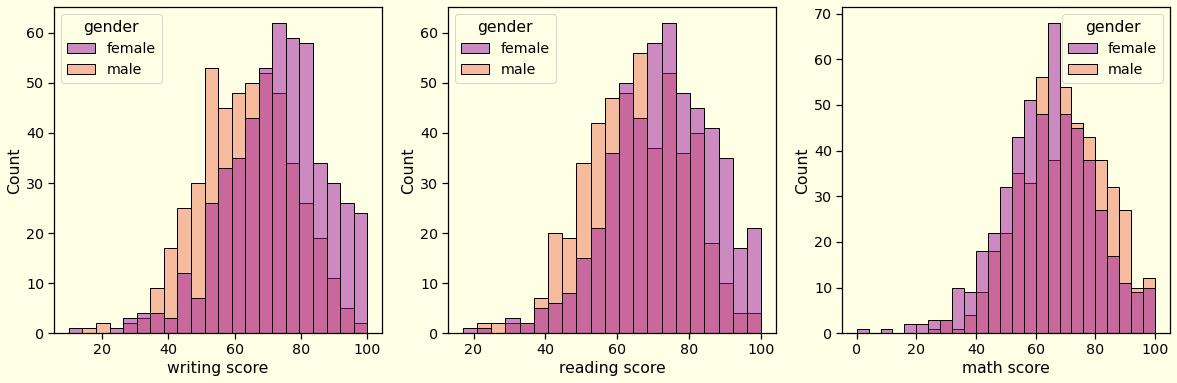

In [14]:
sns.set_context('notebook', font_scale= 1.3)
plt.rcParams['figure.facecolor'] = "#ffffe6"
plt.rcParams['axes.facecolor'] = "#ffffe6"
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
ax1 = sns.histplot(x = data['writing score'], hue = data['gender'] , palette= 'plasma', ax= ax[0])
ax1 = sns.histplot(x = data['reading score'], hue = data['gender'], palette= 'plasma', ax= ax[1])
ax1 = sns.histplot(x = data['math score'], hue = data['gender'], palette= 'plasma', ax= ax[2])

In [15]:
gender_mean_score = data.groupby('gender')[['math score', 'reading score', 'writing score']].mean().round(2).transpose().reset_index()
gender_mean_score = gender_mean_score.rename(columns = {'index':' ','female':'Female','male':'Male'})
s = gender_mean_score.style.hide_index()
s = s.set_table_styles(
   [{
       'selector': 'th',
       'props': [('background-color', '#87CEFA'),('border','solid 1px')]
   },{
       'selector': 'td',
       'props': [('background-color', '#e0ffff'),('border','solid 1px')]
   }])
s

,Female,Male
math score,63.630000,68.730000
reading score,72.610000,65.470000
writing score,72.470000,63.310000


- Females tend to do better than males in both reading and writing
- Males perform better in Maths

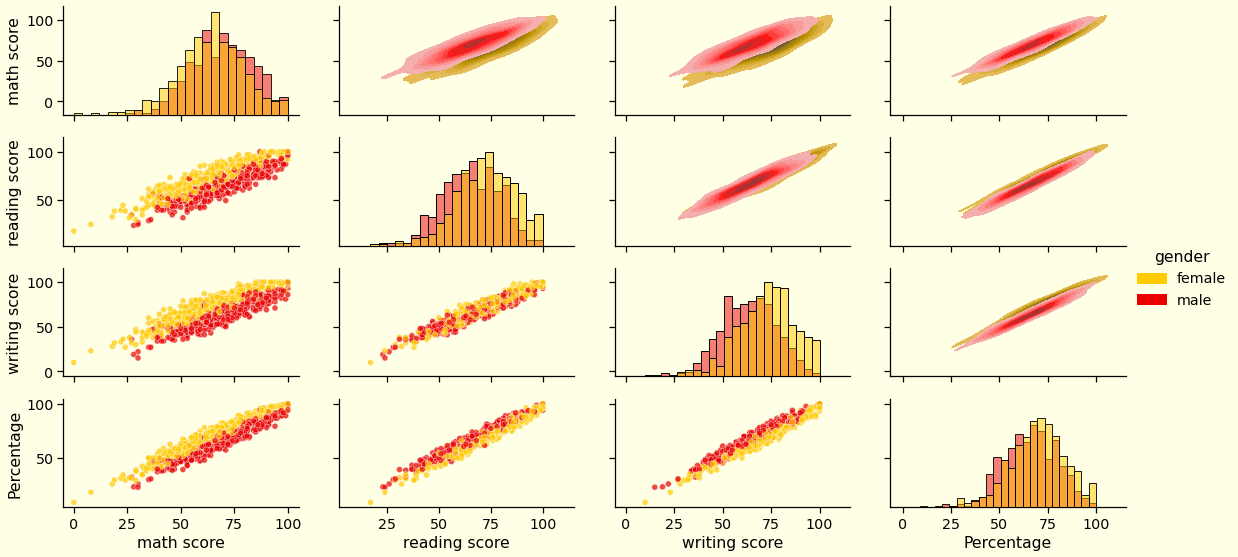

In [16]:
plt.rcParams['figure.facecolor'] = "#ffffe6"
plt.rcParams['axes.facecolor'] = "#ffffe6"

grid = sns.PairGrid(data, vars=['math score', 'reading score', 'writing score', 'Percentage'], hue= 'gender', palette= 'hot_r',
                    height=2, aspect = 2)

grid = grid.map_diag(sns.histplot)
grid = grid.map_lower(sns.scatterplot, alpha =  0.7)
grid = grid.map_upper(sns.kdeplot, n_levels = 10, shade = True)

grid.add_legend()
plt.show()

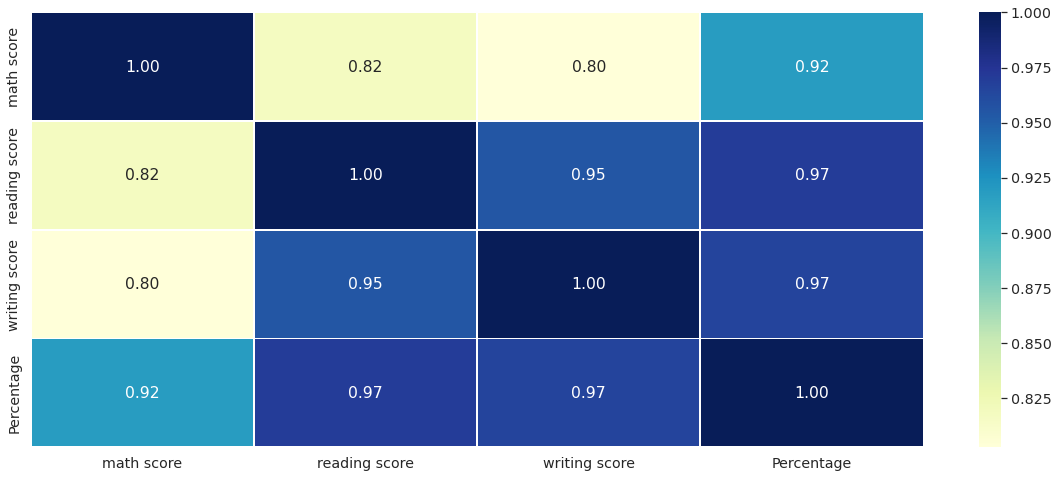

In [17]:
with sns.axes_style('white'):
    plt.figure(figsize= (20, 8))
    sns.heatmap(data.corr(), annot = True, fmt = '.2f', linewidths= 0.8, cmap="YlGnBu")

- Almost all of these scores are highly correlated with each other
- Maths score seems to be the least correlated among these, therefore we will try to predict maths score during modelling

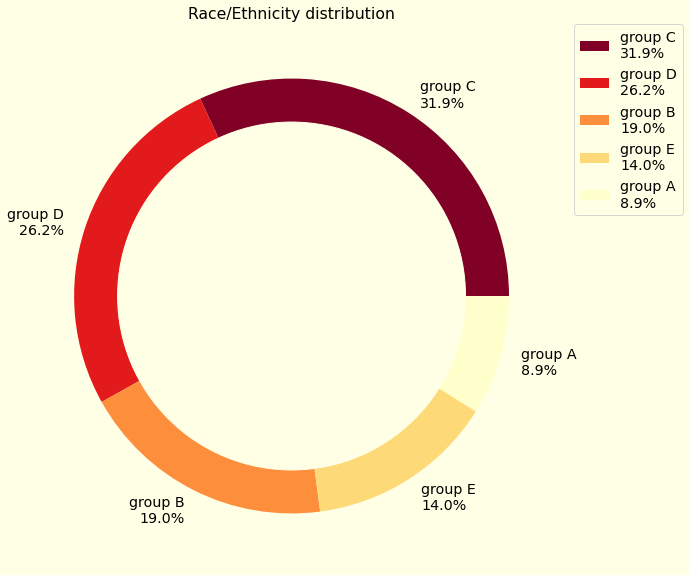

In [18]:
ethnicity = data['race/ethnicity'].value_counts()
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))

names = ethnicity.index.tolist()
values = ethnicity.values.tolist()

cmap = plt.get_cmap("YlOrRd")
cmap = cmap.reversed()
colors = cmap(np.linspace(0, 1, 5))

ax.pie(values, labels = [i[0] + '\n' + str(i[1]/10) + '%'  for i in zip(names,values)],colors = colors)
circle = plt.Circle( (0,0), 0.8, color='#ffffe6')
p=plt.gcf()
p.gca().add_artist(circle)
ax.set_title("Race/Ethnicity distribution")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

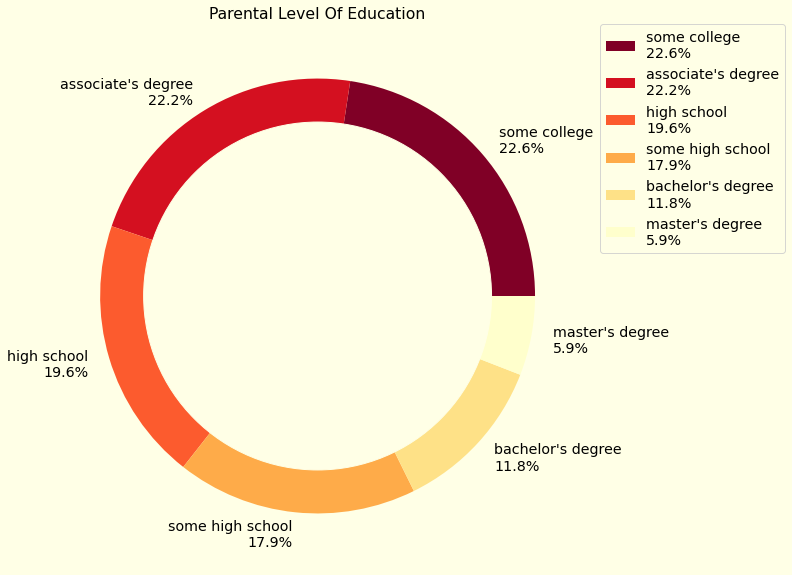

In [19]:
parental_education = data['parental level of education'].value_counts()
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))

names = parental_education.index.tolist()
values = parental_education.values.tolist()

cmap = plt.get_cmap("YlOrRd")
cmap = cmap.reversed()
colors = cmap(np.linspace(0, 1, 6))

ax.pie(values, labels = [i[0] + '\n' + str(i[1]/10) + '%'  for i in zip(names,values)],colors = colors)
circle = plt.Circle( (0,0), 0.8, color='#ffffe6')
p=plt.gcf()
p.gca().add_artist(circle)
ax.set_title("Parental Level Of Education")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

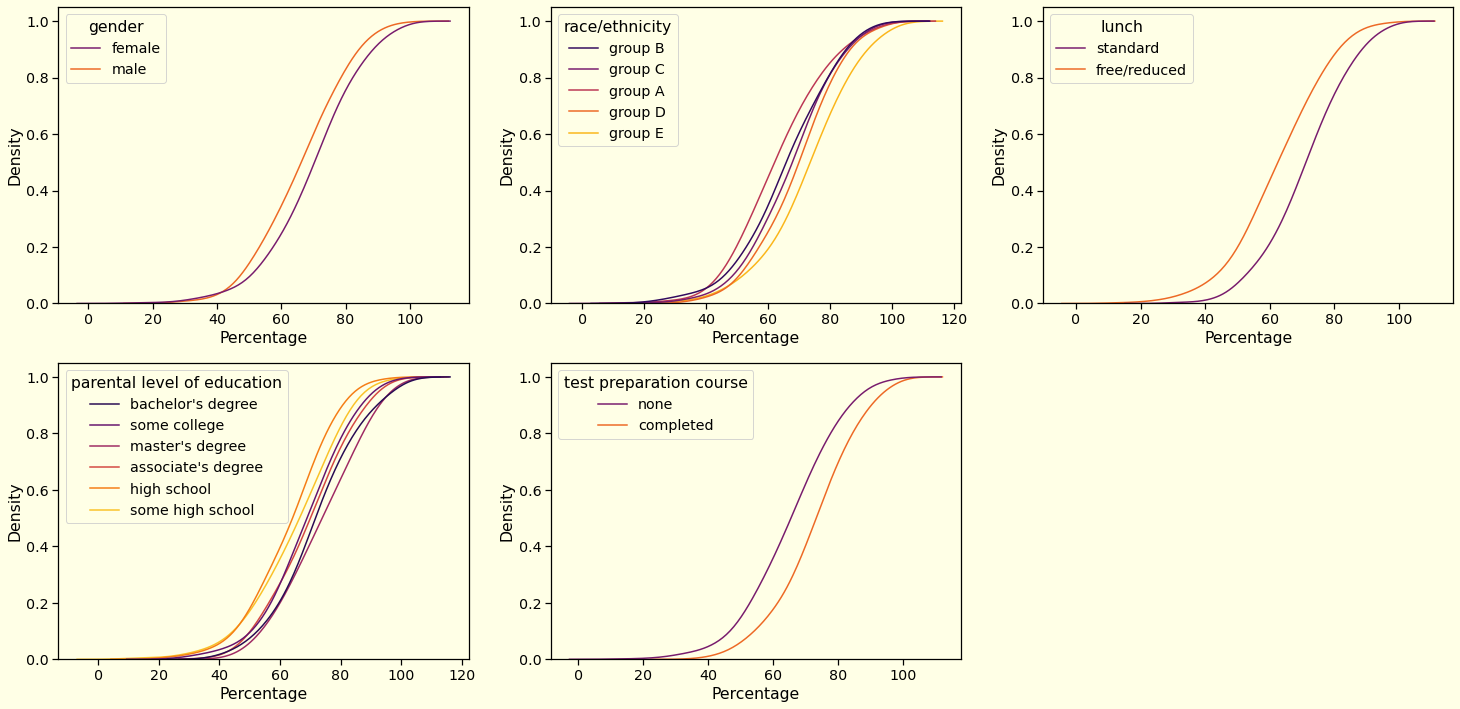

In [20]:
plt.rcParams['figure.facecolor'] = "#ffffe6"
plt.rcParams['axes.facecolor'] = "#ffffe6"

fig, ax = plt.subplots(2, 3, figsize = (25, 12))
ax[1, 2].axis('off')

sns.kdeplot(data = data, x = "Percentage", hue = "gender", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[0, 0])
sns.kdeplot(data = data, x = "Percentage", hue = "race/ethnicity", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[0, 1])
sns.kdeplot(data = data, x = "Percentage", hue = "lunch", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[0, 2])
sns.kdeplot(data = data, x = "Percentage", hue = "parental level of education", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[1, 0])
sns.kdeplot(data = data, x = "Percentage", hue = "test preparation course", palette = 'inferno', cumulative = True, common_norm = False, ax = ax[1, 1])

plt.show()

- Females have higher percentage than males
- Students whose parents holds a master's degree have a higher percentage than others
- Students who completed their course have higher percentage as compared to those who didn't.

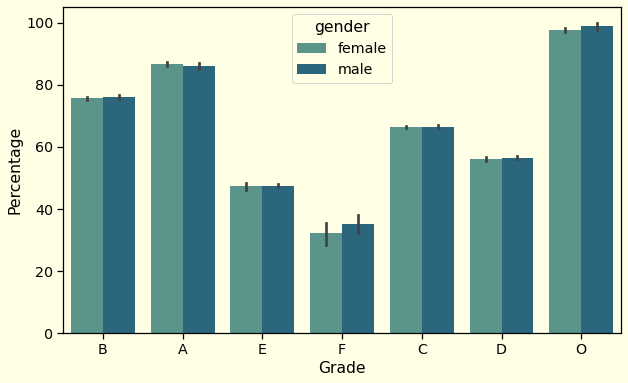

In [21]:
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Grade', y = 'Percentage', data= data, hue= 'gender', palette= 'crest');

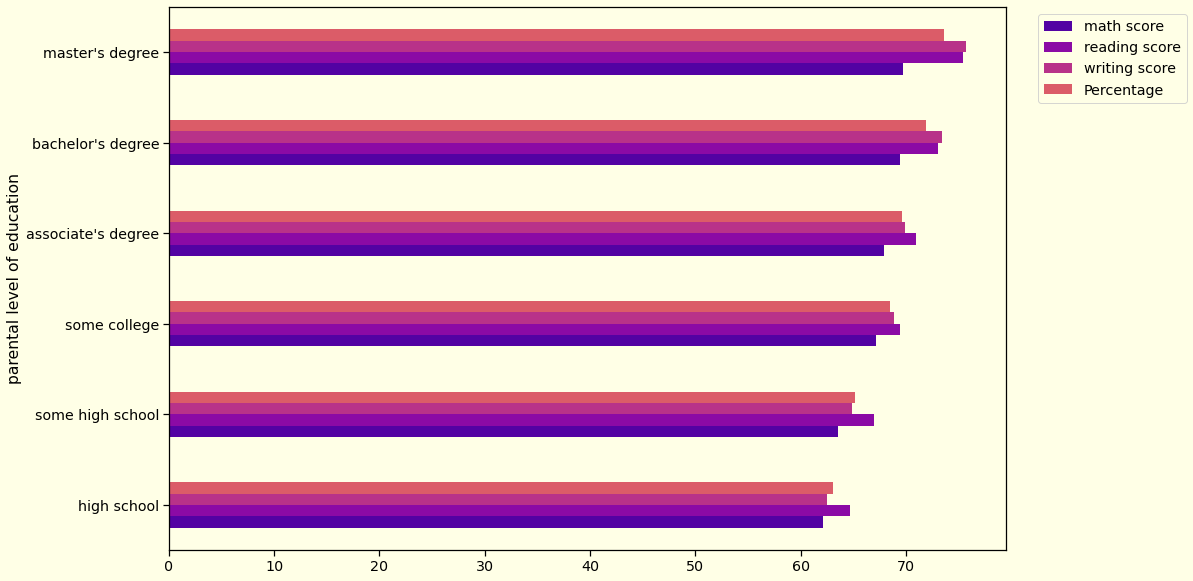

In [22]:
sns.set_palette("plasma")
data.groupby('parental level of education').agg('mean').sort_values(by = 'Percentage').plot(kind='barh',figsize=(15,10))
plt.legend(bbox_to_anchor=(1.03, 1), loc = 2);

- Students whose parents never went to college seems to have the lowest percentage
- Students whose parents have a master's degree performed the best followed by parents having a bachelor's degree

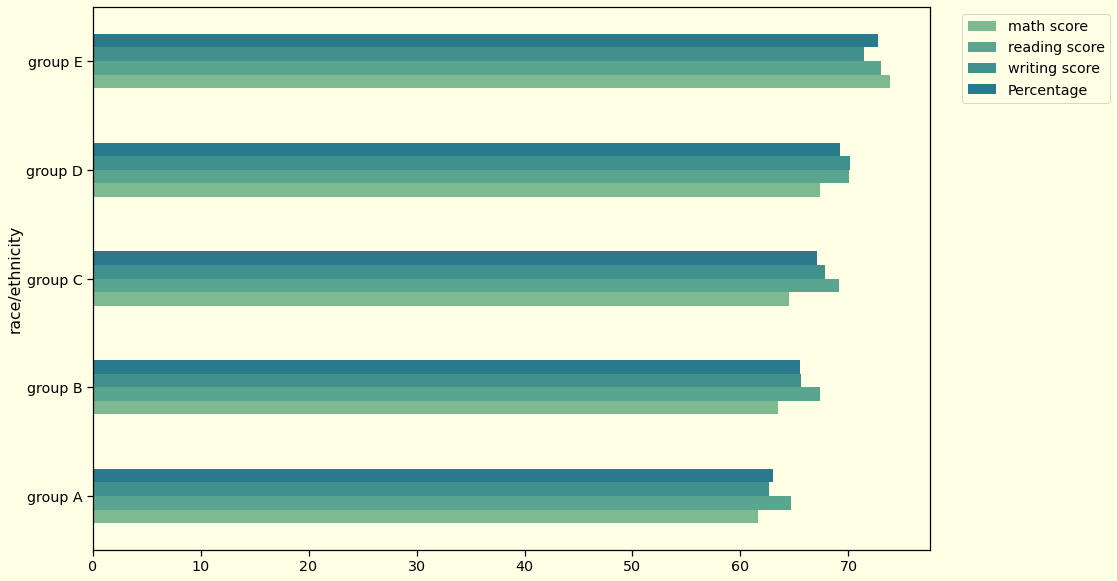

In [23]:
sns.set_palette("crest")
data.groupby('race/ethnicity').agg('mean').sort_values(by = 'Percentage').plot(kind='barh',figsize=(15,10))
plt.legend(bbox_to_anchor=(1.03, 1), loc = 2);

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Cambria";'>
Transformation Pipeline

In [24]:
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, grades_ordering = ['F', 'E', 'D', 'C', 'B', 'A', 'O'],
                 ethnicity_ordering = ['group A', 'group B', 'group C', 'group D', 'group E'],
                 parents_education_ordering = ['high school', 'some high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]):
                 
        self.grades_ordering = grades_ordering
        self.ethnicity_ordering = ethnicity_ordering
        self.parents_education_ordering = parents_education_ordering
    
    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X["Grade"] = X['Grade'].apply(lambda x: self.grades_ordering.index(x))
        X["parental level of education"] = X['parental level of education'].apply(lambda x: self.parents_education_ordering.index(x))
        X["race/ethnicity"] = X['race/ethnicity'].apply(lambda x: self.ethnicity_ordering.index(x))
        return X


In [25]:
num_cols = ['reading score', 'writing score', 'Percentage']
cat_cols = ['gender', 'lunch', 'test preparation course']
ordinal_cols = ['Grade', 'race/ethnicity', 'parental level of education']


In [104]:
pipeline = ColumnTransformer([
    ('std_scaler', StandardScaler(), num_cols),
    ('ord_encode', CustomOrdinalEncoder(), ordinal_cols),
    ('label_encode', OneHotEncoder(), cat_cols)], remainder= 'passthrough')

In [105]:
data['Percentage'] = round((data['reading score'] + data['writing score']) / 2, 2)
data["Grade"] = data['Percentage'].apply(lambda x: Grade(x))

In [106]:
X = data.drop('math score', axis = 1)
y = data['math score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [108]:
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Cambria";'>
Random Forest

In [ ]:
model = RandomForestRegressor(random_state = 42)
model.fit(X_train_prepared, y_train)

kfold = KFold(n_splits= 5)
scores =  - cross_val_score(model, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=kfold)
rmse_scores = np.sqrt(scores)

print(f"Mean: {rmse_scores.mean()}", )
print(f"Standard deviation: {rmse_scores.std()}")

Mean: 6.042128125543862
Standard deviation: 0.18077648360495044


In [ ]:
y_pred = model.predict(X_test_prepared)
rmse = mean_squared_error(y_test, y_pred, squared= False)
r_square = r2_score(y_test, y_pred)

In [ ]:
print(f'Root Mean Squared error: {round(rmse, 3)}')
print(f'R-square: {round(r_square, 3)}')


Root Mean Squared error: 6.141
R-square: 0.845


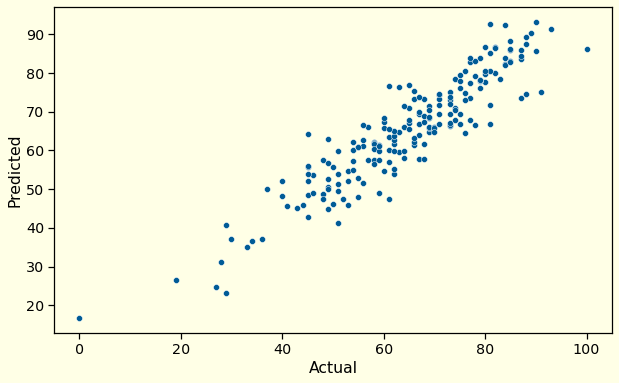

In [ ]:
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= y_pred, color= '#005b96')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Cambria";'>
Hyperparameter Optimization

### **GridSearchCV**

In [ ]:
params = [
    {'n_estimators': [100, 250, 400], 'max_features': [8, 16, 24]},
    {'bootstrap': [False], 'n_estimators': [200, 400], 'max_features': [15, 30]},
  ]

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, params, cv = kfold,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [8, 16, 24],
                          'n_estimators': [100, 250, 400]},
                         {'bootstrap': [False], 'max_features': [15, 30],
                          'n_estimators': [200, 400]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
mean_rmse_grid_search = np.sqrt( - grid_search.best_score_)
print(f'RMSE: {round(mean_rmse_grid_search, 2)}')

RMSE: 5.95


### **RandomizedSearchCV**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params = {
        'n_estimators': randint(low= 200, high=500),
        'max_features': randint(low=10, high=50),
    }

model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(model, params,
                                   n_iter = 10, cv = kfold, scoring='neg_mean_squared_error', random_state=42)

random_search.fit(X_train_prepared, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B98B490FD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B98B3683D0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
mean_rmse_random_search = np.sqrt( - random_search.best_score_)
print(f'RMSE: {round(mean_rmse_random_search, 2)}')

RMSE: 6.0


### **Optuna**

In [ ]:
def random_forest_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    bootstrap = trial.suggest_categorical('bootstrap', ['True', 'False'])

    model = RandomForestRegressor(
        n_estimators= n_estimators,
        max_depth= max_depth,
        bootstrap= bootstrap
    )

    model.fit(X_train_prepared, y_train)
    cv_score = - cross_val_score(model, X_train_prepared, y_train, scoring= 'neg_mean_squared_error', cv= kfold)

    return np.sqrt(np.mean(cv_score))

study = optuna.create_study(direction= 'minimize')
study.optimize(random_forest_objective, n_trials= 10)

[I 2022-10-02 17:09:18,546] A new study created in memory with name: no-name-30ce6f43-db1b-4456-9f53-6f51317bb7bf
[I 2022-10-02 17:09:19,030] Trial 0 finished with value: 6.028940375103782 and parameters: {'n_estimators': 52, 'max_depth': 48, 'bootstrap': 'True'}. Best is trial 0 with value: 6.028940375103782.
[I 2022-10-02 17:09:21,634] Trial 1 finished with value: 6.0233666691887455 and parameters: {'n_estimators': 309, 'max_depth': 13, 'bootstrap': 'False'}. Best is trial 1 with value: 6.0233666691887455.
[I 2022-10-02 17:09:23,871] Trial 2 finished with value: 5.991719671336173 and parameters: {'n_estimators': 266, 'max_depth': 37, 'bootstrap': 'False'}. Best is trial 2 with value: 5.991719671336173.
[I 2022-10-02 17:09:28,110] Trial 3 finished with value: 6.0089404456780136 and parameters: {'n_estimators': 482, 'max_depth': 41, 'bootstrap': 'True'}. Best is trial 2 with value: 5.991719671336173.
[I 2022-10-02 17:09:30,966] Trial 4 finished with value: 6.006094355177872 and paramet

In [ ]:
trial = study.best_trial
print(f'RMSE: {round(trial.value, 2)}')

RMSE: 5.99


In [ ]:
params = {
    'n_estimators': 69,
    'max_depth': 21,
    'bootstrap': 'True'
}

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Cambria";'>
Final Predictions 

In [ ]:
final_model = RandomForestRegressor(**params)
final_model.fit(X_train_prepared, y_train)
final_predictions = final_model.predict(X_test_prepared)

final_rmse = mean_squared_error(y_test, final_predictions, squared= False)
final_rsquare = r2_score(y_test, final_predictions)

In [ ]:
print(f'RMSE: {round(final_rmse, 3)}')
print(f'R-square: {round(final_rsquare, 3)}')


RMSE: 6.306
R-square: 0.837


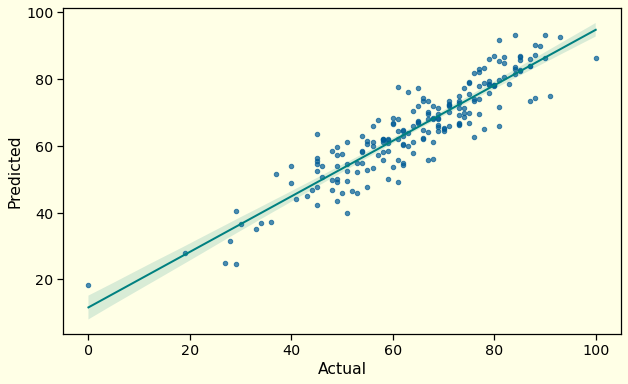

In [ ]:
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize= (10, 6))
sns.regplot(x= y_test, y= final_predictions, scatter_kws = {'s': 20, 'color': '#005b96', 'alpha': 0.7}, 
            line_kws = {'linewidth': 2, 'color': 'teal'})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

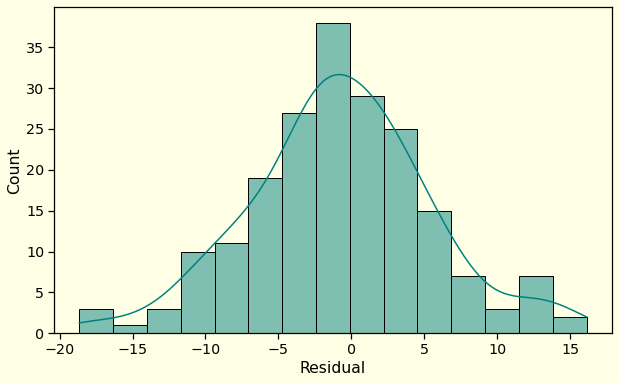

In [ ]:
# Distribution of error
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize= (10, 6))
sns.histplot(y_test - final_predictions, color = 'teal', kde= True)
plt.xlabel('Residual');

#RNN (Bi-LSTM)

In [200]:
def split_data(x, y, time_steps=1):
    xs, ys = [], []
    for i in range(len(x) - time_steps):
        v = x[i:(i + time_steps)]
        xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(xs), np.array(ys)

X_F = pipeline.fit_transform(X)
x_train_prepared, y_train = split_data(X_F, y, 1)
x_test_prepared, y_test = split_data(X_F, y, 1)

X_train_final = np.asarray(x_train_prepared).astype('float32')
print(X_train_final.shape, y_train.shape)

(999, 1, 12) (999,)


In [235]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train_prepared.shape[1], x_train_prepared.shape[-1]))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=False)),
  tf.keras.layers.Dense(1),
])

### Compile & Training

In [236]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [237]:
class my_allback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < 0.1):
            print("MAE below 10%")

    def on_train_end(self, epoch, logs={}):
        print('Done')

callbacks = my_allback()

In [238]:
hasil = model.fit(X_train_final, y_train, epochs=100, validation_split=0.2, callbacks = callbacks)

Epoch 1/100
25/25 [==============================] - 10s 79ms/step - loss: 45.5416 - mae: 46.0375 - val_loss: 22.3602 - val_mae: 22.8548
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 14.4938 - mae: 14.9856 - val_loss: 12.1369 - val_mae: 12.6296
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 11.8029 - mae: 12.2924 - val_loss: 12.5188 - val_mae: 13.0083
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 11.5248 - mae: 12.0155 - val_loss: 12.0274 - val_mae: 12.5179
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 11.5285 - mae: 12.0216 - val_loss: 11.9772 - val_mae: 12.4697
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 11.5409 - mae: 12.0333 - val_loss: 12.0305 - val_mae: 12.5206
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 11.6580 - mae: 12.1506 - val_loss: 12.0210 - val_mae: 12.5125
Epoch 8/100
25/25 [==============================] - 

In [239]:
def split_data(x, y, time_steps=1):
    xs, ys = [], []
    for i in range(len(x) - time_steps):
        v = x[i:(i + time_steps)]
        xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(xs), np.array(ys)

x_test_final, y_test_final = split_data(x_test_prepared, y_test, 1)

In [240]:
prediction = model.predict(x_test_final[1])
print(prediction)

[[67.88551]]


In [241]:
y_test_final[1]

47

### the prediction and actual value is still miss (gap is 20) the MAE is 12-13 on RNN but on random forest the RMSE is 6-7